## **ÇEKİŞMELİ ÜRETİCİ AĞLAR (GANs) İLE SANATSAL STİL AKTARIMI ** 

---
### Kaynak: [Artistic-Style-Transfer](https://github.com/hnarayanan/artistic-style-transfer/blob/master/notebooks/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb)


---


[<img align="left" width="100" height="100" src="http://www.i2symbol.com/images/symbols/style-letters/circled_latin_capital_letter_a_u24B6_icon_128x128.png">](https://www.ayyucekizrak.com/)
[<img align="right" width="200" height="50"  src="https://raw.githubusercontent.com/deeplearningturkiye/pratik-derin-ogrenme-uygulamalari/944a247d404741ba37b9ef74de0716acff6fd4f9/images/dltr_logo.png">](https://deeplearningturkiye.com/)


**Colab** için kimlik doğrulama adımları:

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

drive  images  StilTransferi_GAN.ipynb	stiltransferi_gan.py


In [5]:
import os
os.chdir("/content/drive/Udemy_DerinOgrenmeyeGiris/Cekismeli_Uretici_Aglar-GAN/")
!pwd

/content/drive/Udemy_DerinOgrenmeyeGiris/Cekismeli_Uretici_Aglar-GAN


In [6]:
!ls

drive  images  StilTransferi_GAN.ipynb	stiltransferi_gan.py


### Kütüphane kurulumları:

In [0]:
!pip3 install -q keras

**Gerekli paketleri yükleme işlemleri...**

In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


Drive da ilgili dosyaya git!

In [7]:
!ls 'drive/Udemy_DerinOgrenmeyeGiris/Cekismeli_Uretici_Aglar-GAN/images/'

billie holiday.jpg  hababam.jpg  park.png  styles


### **Test resmini ve stil resmini yükleyerek ön işlemler yapıyoruz**

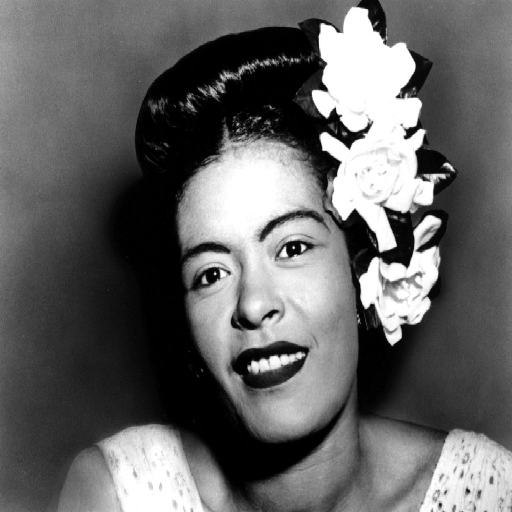

In [0]:
height = 512
width = 512

root = 'drive/Udemy_DerinOgrenmeyeGiris/Cekismeli_Uretici_Aglar-GAN/'
content_image_path = root + 'images/billie holiday.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

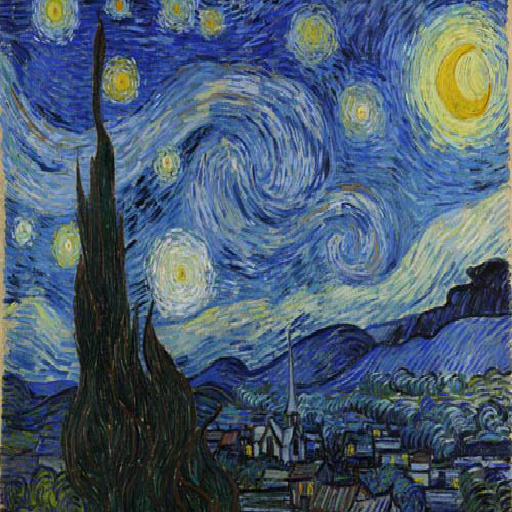

In [0]:
style_image_path = root + 'images/styles/style3.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### **Görüntüleri sayısal işlemek için ortak formata getiriyoruz**

In [0]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


**Her pikselden ortalama RGB değerini çıkarıyoruz (önceden ImageNet eğitim setinde hesaplanmış değerler. Google aramalarında da kolayca bulunabilir).
Çok boyutlu dizinin sıralamasını RGB'den BGR'ye çeviriyoruz.**

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

### **Önceden eğitilmiş modeli kullanalım**

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

### **Modelin yapısına göz atalım**

In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 5

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 40790696000.0
Iteration 0 completed in 20s
Start of iteration 1
Current loss value: 23205534000.0
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 19174220000.0
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 17941220000.0
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 17292726000.0
Iteration 4 completed in 19s


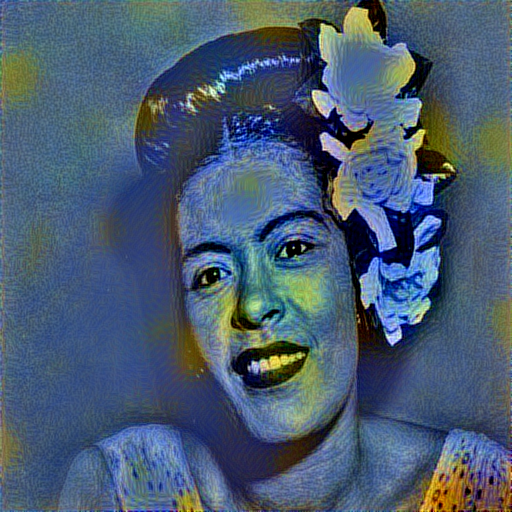

In [0]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)